# 大學特殊選才－－程式作品集-2
# 生物物理：以隨機森林與人工神經網路，預測蛋白質-配體系統的結合親和力

作者： 陳昆毅

**"""""""""""""""""""""""""""""""""""""""""""" 註記 """"""""""""""""""""""""""""""""""""""""""""**
1. 此程式的部分內容是學習自 [Deep Learning for the Life Sciences](https://www.amazon.com/Deep-Learning-Life-Sciences-Microscopy/dp/1492039837) 此書，以 Python 語言撰寫。
1. 此程式為申請大學特殊選才之備審資料中的程式作品集-2。
1. 此程式使用的函式庫無法在 Windows OS 中執行，我是在 Linux OS (Ubuntu) 中執行。 

**""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""**

### 大綱

1. 序言
1. 匯入 PDBBind 資料集，並對其進行特徵化
1. 訓練隨機森林、人工神經網路模型
    - 隨機森林模型
    - 人工神經網路模型
1. 以 $Pearson$ $R^2$ 作為衡量模型預測準確率的標準
1. 對預測結果作圖
    - 隨機森林模型
    - 人工神經網路模型

## (1) 序言

了解小型分子如何在人體中與特定蛋白質產生鍵結，對於潛在藥物的發明是極為重要的；若我們能藉由設計某藥物分子與特定蛋白質產生鍵結，從而將該蛋白質的功能導引至我們想要的方向，這通常會有顯著的治療效果；癌症藥物 [Imatinib](https://en.wikipedia.org/wiki/Imatinib) 的突破，其部分原因是因 Imatinib 能與 BCR-ABL 蛋白質產生鍵結後，成為對數種酪氨酸激酶 (tyrosine kinase enzymes) 的特定抑制劑。

此程式之目的是訓練 2 個機器學習模型 (隨機森林、人工神經網路) 來預測蛋白質-配體系統的結合親和力，並測試 2 個模型的預測表現。

在進行機器學習作業前，我們能用視覺化的工具 ([NGLview](https://github.com/arose/nglview)) 去了解其資料庫的檔案內容；我們以一個 `2d3u.pdb` 檔案作舉例，其為一個 "蛋白質-配體" 的複合物，並以 X-ray crystallography 方式獲得其蛋白質結構 (檔案全名：X-ray crystal structure of hepatitis C virus RNA dependent RNA polymerase in complex with non-nucleoside analogue inhibitor，此 [link](https://www.rcsb.org/structure/2d3u) 為其資訊)；檔案內容包含各個原子在 3D 空間上的座標，座標單位是埃 (angstrom, $1 Å = 10^{-10}meters$)。

執行以下程式前，請先至 [DeepChem 的 GitHub 網頁](https://github.com/deepchem)下載 "[2d3u.pdb](https://github.com/deepchem/DeepLearningLifeSciences/tree/master/Chapter05)" 檔案。

In [1]:
import nglview as nv

view = nv.show_file("2d3u.pdb")
view.representations = [{"type": "cartoon", 
                         "params": {"sele": "protein", 
                                    "color": "residueindex"}},
                        {"type": "ball+stick",
                         "params": {"sele": "ligand"}}]
view

_ColormakerRegistry()

NGLWidget()

<h4 align='center'><img src="https://raw.githubusercontent.com/kunyiC/images/master/protein_1.png" style="width:182px;height:180px;"></h4>

將圖片放大些：

<h4 align='center'><img src="https://raw.githubusercontent.com/kunyiC/images/master/protein_ligend_enlarge.jpg" style="width:440px;height:270px;"></h4>

## (2) 匯入 PDBBind 資料集，並對其進行特徵化

我們以 [PDBBind](https://www.rcsb.org/) 資料庫中的 `core sets` 進行實驗，將資料集中的每個 "蛋白質-配體" 結構進行特徵化後，把 `core sets` 分成3個子資料集 (訓練集、驗證集、測驗集)。 

我們不用自行定義特徵化的方式，若想使用格狀特徵化 (grid featurization)，僅需呼叫 deepchem 的 [MoleculeNet](http://moleculenet.ai/) 模組，並於參數中標記 `featurizer="grid" `，其便會自動執行。為了加速程式執行速度，我先至 DeepChem 的 GitHub 頁面下載並執行 "[get_featurized_pdbbind.sh](https://github.com/deepchem/deepchem/tree/master/examples/pdbbind)" 檔案。

In [13]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_pdbbind(featurizer="grid", 
                                                       split="random", 
                                                       subset="core")

train_dataset, valid_dataset, test_dataset = datasets


Loading featurized and splitted dataset from:
/tmp/from-pdbbind/full_protein-core-grid-random

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


當然，若想自行去定義格狀特徵化的過程，deepchem 亦提供 `RdkitGridFeaturizer` 函式，其將有關 "蛋白質-配體" 結構的化學資訊轉化成一個向量，做為之後機器學習作業所需的輸入資料。

下方程式提供如何設定函式的參數：

In [3]:
grid_featurizer = dc.feat.RdkitGridFeaturizer(
    voxel_width=2.0,
    feature_types=['hbond', 'salt_bridge', 'pi_stack',
                   'cation_pi', 'ecfp', 'splif'],
    sanitize=True, 
    flatten=True)

1. `voxel_width=2.0`：設定[體積像素](https://zh.wikipedia.org/wiki/%E9%AB%94%E7%B4%A0) (Voxel, Volume Pixel) 於格狀 (grid) 中佔2埃個單位。


2. `feature_types`：
    - 設定在該 "蛋白質-配體" 結構中，有哪些生物物理的特徵是 `RdkitGridFeaturizer` 要去偵測的，在此行程式碼有：氫鍵 (hbond)、鹽橋 (salt_bridge)、$\pi-\pi$ 堆積作用  (pi_stack)、陽離子$-\pi$ 交互作用 (cation_pi)。

    - 要求 `RdkitGridFeaturizer` 去計算2種型態的化學指紋向量：[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t) (Extended-Connectivity Fingerprints) 與 [SPLIF](https://pubs.acs.org/doi/10.1021/ci500319f) (Structural Protein–Ligand Interaction Fingerprints)
    
    
3. `sanitize=True`：由於資料庫的資料可能會有異常情況，此參數會嘗試修正其偵測到的格式錯誤 (因有時實驗無法獲得足夠的解析率來辨認蛋白質的部分結構，因而造成該筆資料的部分缺陷)。


4. `flatten=True`：此參數會把每筆輸入資料展開成1維的向量。

## (3) 訓練隨機森林、人工神經網路模型

以下訓練 2 個機器學習模型以比較各模型對蛋白質-配體系統的結合親和力之預測結果。

### (A) 隨機森林模型

In [4]:
from sklearn.ensemble import RandomForestRegressor

# 建立100棵決策樹
sklearn_RandomForest = RandomForestRegressor(n_estimators=100)
model_1 = dc.models.SklearnModel(sklearn_RandomForest)
model_1.fit(train_dataset)

### (B) 人工神經網路模型

使用 `dc.models.MultitaskRegressor` 以建立一個 2 層神經網路模型 (第 1 層有 2,000 個神經元，第 2 層有 1,000 個神經元)，Dropout 設為 0.5 防止過早 overfitting，並訓練此模型 200 次 (`epoch=200`)。

In [ ]:
n_features = train_dataset.X.shape[1]

model_2 = dc.models.MultitaskRegressor(n_tasks=len(tasks), 
                                       n_features=n_features,
                                       layer_sizes=[2000, 1000],
                                       dropouts=0.5, 
                                       learning_rate=0.0003)

model_2.fit(train_dataset, nb_epoch=200)

## (4) 以 $Pearson$ $R^2$ 作為衡量模型預測準確率的標準

我們以 $Pearson$ $R^2$ 的分數作為衡量模型的預測準確度之指標，此分數範圍介於 $[-1, 1]$；當分數為 0 時，指預測情況 (predicted labels) 與真實情況 (true labels) 之間無相關性，意即該模型毫無作用。

In [7]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

以下程式即以 $Pearson$ $R^2$ 作為衡量 2 個機器學習模型於訓練資料集、測試資料集的預測表現。

In [8]:
print("隨機森林模型: \n")
print("Pearson r squared 的訓練分數:")
train_scores_1 = model_1.evaluate(train_dataset, [metric], transformers)
print('')
print("Pearson r squared 的測試分數:")
test_scores_1 = model_1.evaluate(test_dataset, [metric], transformers)

隨機森林模型: 

Pearson r squared 的訓練分數:
computed_metrics: [0.9769913548933936]

Pearson r squared 的測試分數:
computed_metrics: [0.051589835719136404]


In [9]:
print("2-layer 神經網路模型: \n")
print("Pearson r squared 的訓練分數:")
train_scores_2 = model_2.evaluate(train_dataset, [metric], transformers)
print('')
print("Pearson r squared 的測試分數:")
test_scores_2 = model_2.evaluate(test_dataset, [metric], transformers)

2-layer 神經網路模型: 

Pearson r squared 的訓練分數:
computed_metrics: [0.987161688742337]

Pearson r squared 的測試分數:
computed_metrics: [0.23996476831254393]


### 小結

(1) 對於隨機森林模型： 
    
    其在訓練集的預測分數為 0.98，而在測試集的預測分數僅為 0.05；能知道其對於已訓練過的資料之預測表現很好，但對於未看過的資料就表現得極差，從而推得該模型已 overfitting 。

(2) 對於人工神經網路模型：

    其在訓練集的預測分數為 0.99，而在測試集的預測分數為 0.24；同樣與隨機森林面臨 overfitting 的窘境，但表現是比隨機森林還佳。
    

我們將上述結果以作圖來表現－－

## (5) 對預測結果作圖

In [17]:
import matplotlib.pyplot as plt

def img_show(model_name, real_score, pred_score):
    plt.figure(figsize=(6, 4))
    plt.title('Correlation of real values & predicted values for %s' % model_name, 
              fontsize=13)
    plt.scatter(real_score, pred_score)
    plt.xlabel('Real value', fontsize=12)
    plt.ylabel('Pedicted value', fontsize=12)
    plt.show()

### (A) 隨機森林模型

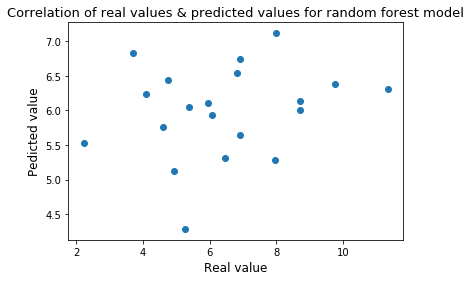

In [18]:
pred_score_1 = model_1.predict(test_dataset)
real_score_1 = test_dataset.y

img_show('random forest model', real_score_1, pred_score_1)

### (B) 人工神經網路模型

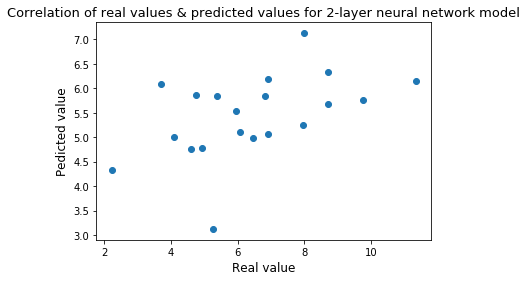

In [19]:
pred_score_2 = model_2.predict(test_dataset)
real_score_2 = test_dataset.y

img_show('2-layer neural network model', real_score_2, pred_score_2)